In [1]:
import json
import os
from pathlib import Path
import time
import copy

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from fastai.dataset import open_image
import json
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import cv2
from tqdm import tqdm

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
SIZE = 224
IMAGES = 'images'
ANNOTATIONS = 'annotations'
CATEGORIES = 'categories'
ID = 'id'
NAME = 'name'
IMAGE_ID = 'image_id'
BBOX = 'bbox'
CATEGORY_ID = 'category_id'
FILE_NAME = 'file_name'

In [3]:
!pwd

/home/paperspace/pytorch-practice/notebooks


In [4]:
!ls $HOME/data/pascal

Annotations  models		    pascal_train2012.json  SegmentationClass
ImageSets    pascal_test2007.json   pascal_val2007.json    SegmentationObject
JPEGImages   pascal_train2007.json  pascal_val2012.json    tmp


In [5]:
!ls ../input/pascal/pascal

ls: cannot access '../input/pascal/pascal': No such file or directory


In [6]:
PATH = Path('/home/paperspace/data/pascal')
list(PATH.iterdir())

[PosixPath('/home/paperspace/data/pascal/ImageSets'),
 PosixPath('/home/paperspace/data/pascal/pascal_train2007.json'),
 PosixPath('/home/paperspace/data/pascal/SegmentationObject'),
 PosixPath('/home/paperspace/data/pascal/pascal_test2007.json'),
 PosixPath('/home/paperspace/data/pascal/pascal_val2012.json'),
 PosixPath('/home/paperspace/data/pascal/SegmentationClass'),
 PosixPath('/home/paperspace/data/pascal/Annotations'),
 PosixPath('/home/paperspace/data/pascal/pascal_val2007.json'),
 PosixPath('/home/paperspace/data/pascal/pascal_train2012.json'),
 PosixPath('/home/paperspace/data/pascal/models'),
 PosixPath('/home/paperspace/data/pascal/JPEGImages'),
 PosixPath('/home/paperspace/data/pascal/tmp')]

In [7]:
train_data = json.load((PATH/'pascal_train2007.json').open())
val_data = json.load((PATH/'pascal_val2007.json').open())
test_data = json.load((PATH/'pascal_test2007.json').open())

print('train:', train_data.keys())
print('val:', val_data.keys())
print('test:', test_data.keys())

train: dict_keys(['images', 'type', 'annotations', 'categories'])
val: dict_keys(['images', 'type', 'annotations', 'categories'])
test: dict_keys(['images', 'type', 'annotations', 'categories'])


In [8]:
train_data[ANNOTATIONS][:1]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0}]

In [9]:
train_data[IMAGES][:2]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17}]

In [10]:
len(train_data[CATEGORIES])

20

In [11]:
next(iter(train_data[CATEGORIES]))

{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}

## Categories - 1th indexed

In [12]:
categories = {c[ID]:c[NAME] for c in train_data[CATEGORIES]}
categories

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [13]:
len(categories)

20

In [14]:
IMAGE_PATH = Path(PATH/'JPEGImages/')
list(IMAGE_PATH.iterdir())[:2]

[PosixPath('/home/paperspace/data/pascal/JPEGImages/006948.jpg'),
 PosixPath('/home/paperspace/data/pascal/JPEGImages/005796.jpg')]

In [15]:
train_filenames = {o[ID]:o[FILE_NAME] for o in train_data[IMAGES]}
print('length:', len(train_filenames))
image1_id, image1_fn = next(iter(train_filenames.items()))
image1_id, image1_fn

length: 2501


(12, '000012.jpg')

In [16]:
train_image_ids = [o[ID] for o in train_data[IMAGES]]
print('length:', len(train_image_ids))
train_image_ids[:5]

length: 2501


[12, 17, 23, 26, 32]

In [17]:
IMAGE_PATH

PosixPath('/home/paperspace/data/pascal/JPEGImages')

In [18]:
image1_path = IMAGE_PATH/image1_fn
image1_path

PosixPath('/home/paperspace/data/pascal/JPEGImages/000012.jpg')

In [19]:
str(image1_path)

'/home/paperspace/data/pascal/JPEGImages/000012.jpg'

In [20]:
im = open_image(str(IMAGE_PATH/image1_fn))
print(type(im))

<class 'numpy.ndarray'>


In [21]:
im.shape

(333, 500, 3)

In [22]:
len(train_data[ANNOTATIONS])

7844

In [23]:
# get the biggest object label per image

In [24]:
train_data[ANNOTATIONS][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [25]:
bbox = train_data[ANNOTATIONS][0][BBOX]
bbox

[155, 96, 196, 174]

In [26]:
def fastai_bb(bb):
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

print(bbox)
print(fastai_bb(bbox))

[155, 96, 196, 174]
[ 96 155 269 350]


In [27]:
fbb = fastai_bb(bbox)
fbb

array([ 96, 155, 269, 350])

In [28]:
def fastai_bb_hw(bb):
    h= bb[3]-bb[1]+1
    w = bb[2]-bb[0]+1
    return [h,w]

fastai_bb_hw(fbb)

[196, 174]

In [29]:
def pascal_bb_hw(bb):
    return bb[2:]

pascal_bb_hw(bbox)

[196, 174]

In [30]:
train_image_w_area = {i:None for i in train_image_ids}
print(image1_id, train_image_w_area[image1_id])

12 None


In [31]:
for x in train_data[ANNOTATIONS]:
    bbox = x[BBOX]
    new_category_id = x[CATEGORY_ID]
    image_id = x[IMAGE_ID]
    h, w = pascal_bb_hw(bbox)
    new_area = h*w
    cat_id_area = train_image_w_area[image_id]
    if not cat_id_area:
        train_image_w_area[image_id] = (new_category_id, new_area)
    else:
        category_id, area = cat_id_area
        if new_area > area:
            train_image_w_area[image_id] = (new_category_id, new_area)

In [32]:
train_image_w_area[image1_id]

(7, 34104)

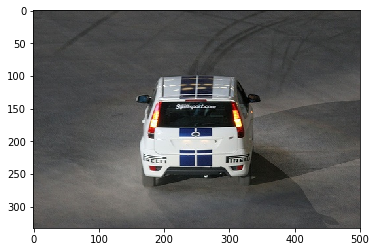

In [33]:
plt.imshow(im)

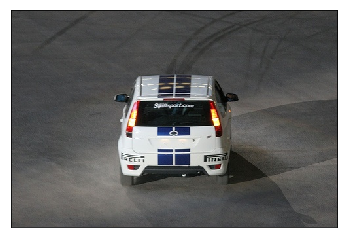

In [34]:
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

show_img(im)

In [35]:
# show_img(im)
# b = bb_hw(im0_a[0])
# draw_rect(ax, b)
image1_fn

'000012.jpg'

In [36]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [37]:
image1_id

12

In [38]:
image1_path

PosixPath('/home/paperspace/data/pascal/JPEGImages/000012.jpg')

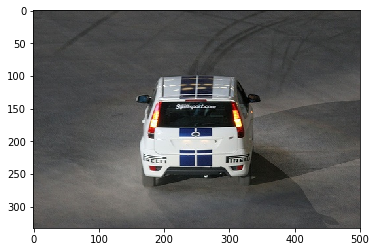

In [39]:
plt.imshow(open_image(str(image1_path)))

In [40]:
train_data[ANNOTATIONS][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

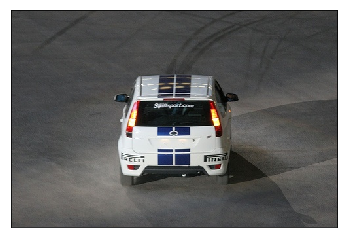

In [41]:
im = open_image(str(image1_path))
ax = show_img(im)

In [42]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [43]:
image1_ann = train_data[ANNOTATIONS][0]
b = fastai_bb(image1_ann[BBOX])
b

array([ 96, 155, 269, 350])

In [44]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

[155, 96, 196, 174]


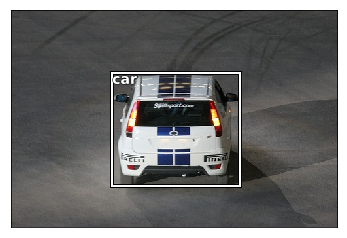

In [45]:
ax = show_img(im)
b = image1_ann[BBOX]
print(b)
draw_rect(ax, b)
draw_text(ax, b[:2], categories[image1_ann[CATEGORY_ID]])

In [46]:
# create a Pandas dataframe for: image_id, filename, category
BIGGEST_OBJECT_CSV = '../input/pascal/pascal/tmp/biggest-object.csv'
IMAGE = 'image'
CATEGORY = 'category'

train_df = pd.DataFrame({
    IMAGE_ID: image_id,
    IMAGE: str(IMAGE_PATH/image_fn),
    CATEGORY: train_image_w_area[image_id][0]
} for image_id, image_fn in train_filenames.items())

train_df.head()

,category,image,image_id
0,7,/home/paperspace/data/pascal/JPEGImages/000012...,12
1,13,/home/paperspace/data/pascal/JPEGImages/000017...,17
2,15,/home/paperspace/data/pascal/JPEGImages/000023...,23
3,7,/home/paperspace/data/pascal/JPEGImages/000026...,26
4,1,/home/paperspace/data/pascal/JPEGImages/000032...,32


In [47]:
# NOTE: won't work in Kaggle Kernal b/c read-only file system
# train_df.to_csv(BIGGEST_OBJECT_CSV, index=False)

In [48]:
train_df.iloc[0]

category                                                    7
image       /home/paperspace/data/pascal/JPEGImages/000012...
image_id                                                   12
Name: 0, dtype: object

In [49]:
len(train_df)

2501

In [50]:
class BiggestObjectDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        im = open_image(self.df.iloc[idx][IMAGE]) # HW
        resized_image = cv2.resize(im, (SIZE, SIZE)) # HW
        image = np.transpose(resized_image, (2, 0, 1)) # CHW
        
        category =  self.df.iloc[idx][CATEGORY]

        return image, category
    
dataset = BiggestObjectDataset(train_df)
inputs, label = dataset[0]

In [51]:
label

7

In [52]:
inputs.shape

(3, 224, 224)

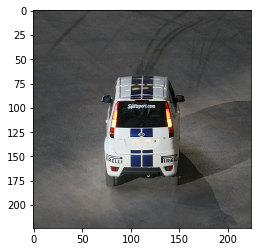

In [53]:
hwc_image = np.transpose(inputs, (1, 2, 0))
plt.imshow(hwc_image)

# DataLoader

In [54]:
BATCH_SIZE = 64
NUM_WORKERS = 4

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=NUM_WORKERS)

batch_inputs, batch_labels = next(iter(dataloader))

In [55]:
batch_inputs.size()

torch.Size([64, 3, 224, 224])

In [56]:
batch_labels

tensor([ 3, 15,  6, 15, 15, 12, 17,  8, 10,  1, 15,  3, 18,  3,  2, 15,  7, 11,
        15, 18, 18, 12,  7, 19, 15, 19, 12,  7, 15,  1, 13, 15,  7,  7,  9, 15,
        13, 18, 16,  8,  7, 15,  9,  5,  1,  9,  8, 12, 15, 12,  9, 15, 15, 15,
        15,  9,  9,  4, 15,  3,  3, 15, 19, 15])

diningtable
(3, 224, 224)


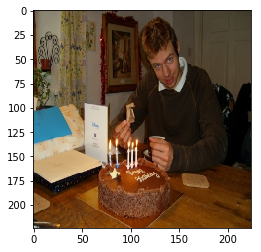

In [57]:
np_batch_inputs = batch_inputs.numpy()
i = np.random.randint(0,20)
print(categories[batch_labels[i].item()])
chw_image = np_batch_inputs[i]
print(chw_image.shape)
hwc_image = np.transpose(chw_image, (1, 2, 0))
plt.imshow(hwc_image)

In [58]:
NUM_CATEGORIES = len(categories)
NUM_CATEGORIES

20

## train the model

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print('device:', device)

model_ft = models.resnet18(pretrained=True)

# freeze pretrained model
for layer in model_ft.parameters():
    layer.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
print('final layer in/out:', num_ftrs, NUM_CATEGORIES)

model_ft.fc = nn.Linear(num_ftrs, NUM_CATEGORIES)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

device: cuda:0
final layer in/out: 512 20


In [74]:
EPOCHS = 10

epoch_losses = []
epoch_accuracies = []

for epoch in range(EPOCHS):
    print('epoch:', epoch)
    running_loss = 0.0
    running_correct = 0

    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # clear gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, dim=1)
        labels_0_indexed = labels-1
        loss = criterion(outputs, labels_0_indexed)
        
        # backwards pass
        loss.backward()
        optimizer.step()
        
        # step stats
        running_loss += loss.item() * inputs.size(0)
        running_correct += torch.sum(preds == labels_0_indexed)
        
    # epoch stats
    epoch_loss = running_loss / len(dataset)
    epoch_acc = running_correct.double().item() / len(dataset)
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_acc)
    print('loss:', epoch_loss, 'acc:', epoch_acc)

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 0


  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.5142463686369935 acc: 0.8284686125549781
epoch: 1


  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.530363380098667 acc: 0.8276689324270292
epoch: 2


  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.45831117006551264 acc: 0.8476609356257497
epoch: 3


  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.4099175357332424 acc: 0.8724510195921631
epoch: 4


  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.3822746812606134 acc: 0.8792483006797281
epoch: 5


  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.369738096418213 acc: 0.8796481407437026
epoch: 6


  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.3476955308193495 acc: 0.8932427029188325
epoch: 7


  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.34716440989274305 acc: 0.8904438224710116
epoch: 8


  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.33104800053092776 acc: 0.8960415833666533
epoch: 9


100%|██████████| 40/40 [00:06<00:00,  6.58it/s]

loss: 0.29960414133325475 acc: 0.9092363054778089


In [77]:
epoch_losses

[0.5142463686369935,
 0.530363380098667,
 0.45831117006551264,
 0.4099175357332424,
 0.3822746812606134,
 0.369738096418213,
 0.3476955308193495,
 0.34716440989274305,
 0.33104800053092776,
 0.29960414133325475]

In [75]:
epoch_accuracies

[0.8284686125549781,
 0.8276689324270292,
 0.8476609356257497,
 0.8724510195921631,
 0.8792483006797281,
 0.8796481407437026,
 0.8932427029188325,
 0.8904438224710116,
 0.8960415833666533,
 0.9092363054778089]

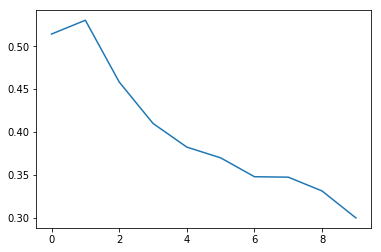

In [78]:
plt.plot(epoch_losses)

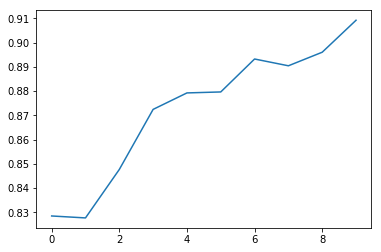

In [79]:
plt.plot(epoch_accuracies)